## Predicting numeric values regression

- Pros: Easy to interpret results, computationally inexpensive
- Cons: Poorly models nonlinear data
- Works with: Numeric values, nominal values

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Implement Linear Regression

Linear Regression: $\theta=(X^TX)^{-1}X^Ty$

In [2]:
# Standard regression function and data-importing functions
def standRegres(xArr, yArr):
    xTx = np.dot(xArr.T, xArr)
    if np.linalg.det(xTx) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return
    ws = np.dot(np.linalg.inv(xTx),
                np.dot(xArr.T, yArr[:, np.newaxis]))
    return ws

Locally Weighted Linear Regression: $\theta=(X^TWX)^{-1}X^TWy$

In [3]:
# Locally weighted linear regression function
def lwlr(testPoint, xArr, yArr, k=1.0):
    m = xArr.shape[0]
    # Create diagonal matrix
    weights = np.eye(m)
    for j in range(m):
        diffMat = testPoint - xArr[j]
        # Populate weights with exponentially decaying values
        weights[j, j] = np.exp(np.dot(diffMat, diffMat) / (-2 * k ** 2))
    xTx = np.dot(xArr.T, np.dot(weights, xArr))
    if np.linalg.det(xTx) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return
    ws = np.dot(np.linalg.inv(xTx),
                np.dot(xArr.T, np.dot(weights, yArr[:, np.newaxis])))
    return np.dot(testPoint, ws)[0]


def lwlrTest(testArr, xArr, yArr, k=1.0):
    m = testArr.shape[0]
    yHat = np.zeros(m)
    for i in range(m):
        yHat[i] = lwlr(testArr[i], xArr, yArr, k)
    return yHat

In [4]:
def rssError(yArr, yHatArr):
    return ((yArr - yHatArr) ** 2).sum()

Ridge Regression: $\theta=(X^TX+\lambda I)^{-1}X^Ty$

In [5]:
# Ridge regression
def ridgeRegres(xArr, yArr, lam=0.2):
    xTx = np.dot(xArr.T, xArr)
    denom = xTx + np.eye(xArr.shape[1]) * lam
    if np.linalg.det(denom) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return
    ws = np.dot(np.linalg.inv(denom),
                np.dot(xArr.T, yArr[:, np.newaxis]))
    return ws


def ridgeTest(xArr, yArr):
    # Normalization code
    yMean = np.mean(yArr)
    yArr = yArr - yMean
    xMeans = np.mean(xArr, axis=0)
    xStd = np.std(xArr, axis=0)
    xArr = (xArr - xMeans) / xStd
    numTestPts = 30
    wMat = np.zeros((numTestPts, xArr.shape[1]))
    for i in range(numTestPts):
        ws = ridgeRegres(xArr, yArr, np.exp(i - 10))
        wMat[i, :] = ws.ravel()
    return wMat

In [6]:
# Forward stagewise linear regression
# Regularize the data to have 0 mean and unit variance
# For every iteration:
#     Set lowestError to + Inf
#     For every feature:
#         For increasing and decreasing:
#             Change one coefficient to get a new W
#             Calculate the Error with new W
#             If the Error is lower than lowestError:
#               set Wbest to the current W
#     Update set W to Wbest
def regularize(xArr):
    inArr = xArr.copy()
    inMeans = np.mean(inArr, axis=0)
    inStd = np.std(inArr, axis=0)
    inArr = (inArr - inMeans) / inStd
    return inArr


def stageWise(xArr, yArr, eps=0.01, numIt=100):
    yMean = np.mean(yArr)
    yArr = yArr - yMean
    xArr = regularize(xArr)
    m, n = xArr.shape
    returnMat = np.zeros((numIt, n))
    ws = np.zeros(n)
    wsTest = ws.copy()
    wsMax = ws.copy()
    for i in range(numIt):
        lowestError = np.inf
        for j in range(n):
            for sign in [-1, 1]:
                wsTest = ws.copy()
                wsTest[j] += eps * sign
                yTest = np.dot(xArr, wsTest)
                rssE = rssError(yArr, yTest)
                if rssE < lowestError:
                    lowestError = rssE
                    wsMax = wsTest
        ws = wsMax.copy()
        returnMat[i] = ws
    return returnMat

### Experiment 1: Toy dataset

In [7]:
def loadDataSet(fileName):
    numFeat = len(open(fileName).readline().split('\t')) - 1
    dataMat, labelMat = [], []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = []
        curLine = line.strip().split('\t')
        for i in range(numFeat):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return np.array(dataMat), np.array(labelMat)

In [8]:
# Linear Regression

In [9]:
xArr, yArr = loadDataSet('ex0.txt')

In [10]:
ws = standRegres(xArr, yArr)
print(ws.ravel())

[3.00774324 1.69532264]


In [11]:
yHat = np.dot(xArr, ws).ravel()
print(yHat[:5])

[3.12257084 3.73301922 4.69582855 4.25946098 4.67099547]


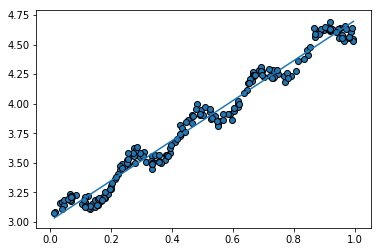

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(xArr[:, 1], yArr, edgecolors="black")
xCopy = xArr.copy()
xCopy.sort(axis=0)
yHat = np.dot(xCopy, ws).ravel()
ax.plot(xCopy[:, 1], yHat)
plt.show()

In [13]:
yHat = np.dot(xArr, ws)
np.corrcoef(yHat.ravel(), yArr)

array([[1.        , 0.98647356],
       [0.98647356, 1.        ]])

In [14]:
# Locally Weighted Linear Regression

In [15]:
xArr, yArr = loadDataSet('ex0.txt')

In [16]:
lwlr(xArr[0], xArr, yArr, 1.0)

3.122044714056868

In [17]:
lwlr(xArr[0], xArr, yArr, 0.001)

3.201757285525254

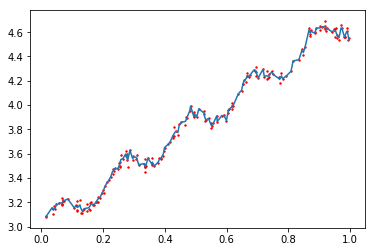

In [18]:
yHat = lwlrTest(xArr, xArr, yArr, 0.003)
srtInd = xArr[:, 1].argsort(axis=0)
xSort = xArr[srtInd]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xSort[:, 1], yHat[srtInd])
ax.scatter(xArr[:, 1], yArr, s=2, c='red')
plt.show()

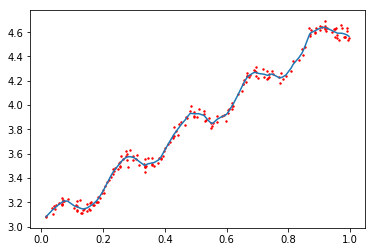

In [19]:
yHat = lwlrTest(xArr, xArr, yArr, 0.01)
srtInd = xArr[:, 1].argsort(axis=0)
xSort = xArr[srtInd]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xSort[:, 1], yHat[srtInd])
ax.scatter(xArr[:, 1], yArr, s=2, c='red')
plt.show()

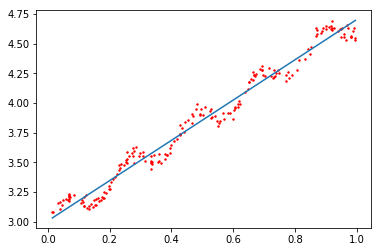

In [20]:
yHat = lwlrTest(xArr, xArr, yArr, 1)
srtInd = xArr[:, 1].argsort(axis=0)
xSort = xArr[srtInd]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xSort[:, 1], yHat[srtInd])
ax.scatter(xArr[:, 1], yArr, s=2, c='red')
plt.show()

### Experiment 2: Abalone dataset

In [21]:
abX, abY = loadDataSet('abalone.txt')

In [22]:
# Locally Weighted Linear Regression

In [23]:
yHat01 = lwlrTest(abX[0: 99], abX[0: 99], abY[0: 99], 0.1)
yHat1 = lwlrTest(abX[0: 99], abX[0: 99], abY[0: 99], 1)
yHat10 = lwlrTest(abX[0: 99], abX[0: 99], abY[0: 99], 10)
print(rssError(abY[0: 99], yHat01))
print(rssError(abY[0: 99], yHat1))
print(rssError(abY[0: 99], yHat10))

56.78420911837208
429.89056187030394
549.1181708826065


In [24]:
yHat01 = lwlrTest(abX[100: 199], abX[0: 99], abY[0: 99], 0.1)
yHat1 = lwlrTest(abX[100: 199], abX[0: 99], abY[0: 99], 1)
yHat10 = lwlrTest(abX[100: 199], abX[0: 99], abY[0: 99], 10)
print(rssError(abY[100: 199], yHat01))
print(rssError(abY[100: 199], yHat1))
print(rssError(abY[100: 199], yHat10))

25119.459111157415
573.5261441895706
517.5711905381745


In [25]:
# Linear Regression

In [26]:
ws = standRegres(abX[0: 99], abY[0: 99])
yHat = np.dot(abX[100: 199], ws).ravel()
print(rssError(abY[100: 199], yHat))

518.6363153249081


In [27]:
# Ridge Regression

In [28]:
abX, abY = loadDataSet('abalone.txt')

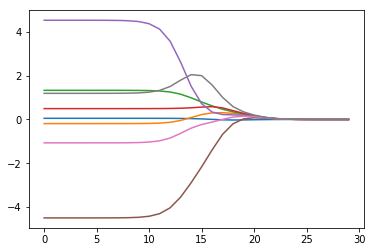

In [29]:
ridgeWeights = ridgeTest(abX, abY)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ridgeWeights)
plt.show()

In [30]:
# Forward Stagewise Linear Regression

In [31]:
xArr, yArr = loadDataSet('abalone.txt')

In [32]:
stageWise(xArr, yArr, 0.01, 200)

array([[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.01],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.02],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.03],
       ...,
       [ 0.  ,  0.  ,  0.  , ..., -0.07,  0.  ,  1.59],
       [ 0.  ,  0.  ,  0.  , ..., -0.07,  0.  ,  1.6 ],
       [ 0.  ,  0.  ,  0.  , ..., -0.08,  0.  ,  1.6 ]])

In [33]:
stageWise(xArr, yArr, 0.005, 5000)

array([[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.005],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.01 ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.015],
       ...,
       [ 0.055, -0.11 ,  1.245, ..., -4.39 , -1.005,  1.295],
       [ 0.05 , -0.11 ,  1.245, ..., -4.39 , -1.005,  1.295],
       [ 0.055, -0.11 ,  1.245, ..., -4.39 , -1.005,  1.295]])

In [34]:
xArr, yArr = loadDataSet('abalone.txt')
xArr = regularize(xArr)
yMean = np.mean(yArr)
yArr = yArr - yMean
weights = standRegres(xArr, yArr)
weights.ravel()

array([ 0.05235616, -0.18938966,  1.33168957,  0.49619321,  4.53579572,
       -4.50107876, -1.06982725,  1.19429503])

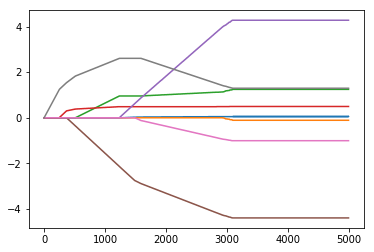

In [35]:
xArr, yArr = loadDataSet('abalone.txt')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(stageWise(xArr, yArr, 0.005, 5000))
plt.show()

### Experiment 3: LEGO set dataset

In [36]:
# Shopping information retrieval function
# Load from local cache, unable to retrieve NewOrUsed feature
def searchForSet(retX, retY, setNum, yr, numPce, origPrc):
    file_name = "setHtml/lego" + str(setNum) + ".html"
    input_file = open(file_name, encoding="utf8")
    page = input_file.read()
    input_file.close()
    pattern = re.compile(r'\$([\d,]+\.\d+)')
    result = pattern.findall(page)
    for price in result:
        price = price.replace(",", "")
        # Filter out fractional sets
        if float(price) <= origPrc * 0.5:
            continue
        retX.append([yr, numPce, origPrc])
        retY.append(float(price))


def setDataCollect(retX, retY):
    searchForSet(retX, retY, 8288, 2006, 800, 49.99)
    searchForSet(retX, retY, 10030, 2002, 3096, 269.99)
    searchForSet(retX, retY, 10179, 2007, 5195, 499.99)
    searchForSet(retX, retY, 10181, 2007, 3428, 199.99)
    searchForSet(retX, retY, 10189, 2008, 5922, 299.99)
    searchForSet(retX, retY, 10196, 2009, 3263, 249.99)

In [37]:
lgX, lgY = [], []
setDataCollect(lgX, lgY)
lgX, lgY = np.array(lgX), np.array(lgY)

In [38]:
lgX1 = np.ones((82, 4))
lgX1[:, 1: 4] = lgX
ws = standRegres(lgX1, lgY)
print(ws.ravel())

[ 5.09659003e+04 -2.54263163e+01 -2.92992001e-02  2.66427939e+00]


In [39]:
# Cross-validation testing with ridge regression
def crossValidation(xArr, yArr, numVal=10):
    m = len(yArr)
    indexList = list(range(m))
    errorMat = np.zeros((numVal, 30))
    for i in range(numVal):
        # Create training and test containers
        trainX, trainY = [], []
        testX, testY = [], []
        np.random.shuffle(indexList)
        for j in range(m):
            # Split data into test and training sets
            if j < m * 0.9:
                trainX.append(xArr[indexList[j]])
                trainY.append(yArr[indexList[j]])
            else:
                testX.append(xArr[indexList[j]])
                testY.append(yArr[indexList[j]])
        trainX, trainY = np.array(trainX), np.array(trainY)
        testX, testY = np.array(testX), np.array(testY)
        wMat = ridgeTest(trainX, trainY)
        # Regularize test with training params
        meanTrain = np.mean(trainX, axis=0)
        stdTrain = np.std(trainX, axis=0)
        testX = (testX - meanTrain) / stdTrain
        for k in range(30):
            yEst = (np.dot(testX, wMat[k][:, np.newaxis]).ravel()
                    + np.mean(trainY))
            errorMat[i, k] = rssError(yEst, testY)
    meanErrors = np.mean(errorMat, axis=0)
    bestWeights = wMat[np.argmin(meanErrors)]
    # Undo regularization
    # can unregularize to get model
    # when we regularized we wrote Xreg = (x - meanX) / std(x)
    # we can now write in terms of x not Xreg:
    # x * w / std(x) - meanX * w / std(x) + meanY
    meanX = np.mean(xArr, axis=0)
    stdX = np.std(xArr, axis=0)
    unReg = bestWeights / stdX
    print("the best model from Ridge Regression is:\n", unReg)
    print("with constant term: ",
          -1 * np.dot(meanX, unReg) + np.mean(yArr))

In [40]:
crossValidation(lgX, lgY, 10)

the best model from Ridge Regression is:
 [-2.81344817e+01 -2.18803214e-02  2.37756862e+00]
with constant term:  56463.16363285567
